##### 1. Fetching data from the dataset


In [9]:
import requests
from bs4 import BeautifulSoup
import json

url = "https://www.gutenberg.org/cache/epub/59824/pg59824-images.html"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Titles are displayed in <h4> and <h5>
# tags , while the poem themselves are
# displayed in <p> tags.    


# The first few tags are not useful

titles = soup.find_all(['h4', 'h5'])[7:]                                    
poems = soup.find_all('p')[8:]

poems_data = []
for title, poem in zip(titles, poems):
    poems_data.append({
        "title": title.text.strip(),
        "content": poem.text.strip()
    })

with open('Robert_Frost_Poem_Collection.json', 'w') as f:
    json.dump(poems_data, f, indent=4)

# !!! The data is still not proper.
# Additional Manual cleaning of data needs to be done.

# The file name is intentionally written as Robert_Frost_Poem_Collection and not Robert_Frost_Poem_Collections 
# so as not to accidentally write over the previous file.


#### 2. Tokenization

In [2]:
# This is the sample implementation of BPE in tiktoken (https://github.com/openai/tiktoken/blob/main/tiktoken/_educational.py)
# It is modified to work with our code.


"""This is an educational implementation of the byte pair encoding algorithm."""
import collections
import regex

gpt2_regex = (r"""'s|'t|'re|'ve|'m|'ll|'d| ?[\p{L}]+| ?[\p{N}]+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""" )
gpt4_regex = (r"""'(?i:[sdmt]|ll|ve|re)|[^\r\n\p{L}\p{N}]?+\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]++[\r\n]*|\s*[\r\n]|\s+(?!\S)|\s+""")

class SimpleBytePairEncoding:
    def __init__(self, *, mergeable_ranks: dict[bytes, int]) -> None:
        """Creates an Encoding object."""
        # A regex pattern string that is used to split the input text
        self.pat_str = gpt4_regex
        # A dictionary mapping token bytes to their ranks. The ranks correspond to merge priority
        self.mergeable_ranks = mergeable_ranks

        self._decoder = {token: token_bytes for token_bytes, token in mergeable_ranks.items()}
        self._pat = regex.compile(gpt4_regex)

    def encode(self, text: str) -> list[int]:
        """Encodes a string into tokens.

        >>> enc.encode("hello world")
        [388, 372]
        """
        # Use the regex to split the text into (approximately) words
        words = self._pat.findall(text)
        tokens = []
        for word in words:
            # Turn each word into tokens, using the byte pair encoding algorithm
            word_bytes = word.encode("utf-8")
            word_tokens = bpe_encode(self.mergeable_ranks, word_bytes)
            tokens.extend(word_tokens)
        return tokens
    
    def decode_bytes(self, tokens: list[int]) -> bytes:
        """Decodes a list of tokens into bytes.

        >>> enc.decode_bytes([388, 372])
        b'hello world'
        """
        return b"".join(self._decoder[token] for token in tokens)

    def decode(self, tokens: list[int]) -> str:
        """Decodes a list of tokens into a string.

        Decoded bytes are not guaranteed to be valid UTF-8. In that case, we replace
        the invalid bytes with the replacement character "�".

        >>> enc.decode([388, 372])
        'hello world'
        """
        return self.decode_bytes(tokens).decode("utf-8", errors="replace")

    @staticmethod
    def train(training_data: str, vocab_size: int):
        """Train a BPE tokeniser on some data!"""
        mergeable_ranks = bpe_train(data=training_data, vocab_size=vocab_size)
        return SimpleBytePairEncoding(mergeable_ranks=mergeable_ranks)


def bpe_encode(mergeable_ranks: dict[bytes, int], input: bytes) -> list[int]:
    parts = [bytes([b]) for b in input]
    while True:

        # Iterate over all pairs and find the pair we want to merge the most
        min_idx = None
        min_rank = None
        for i, pair in enumerate(zip(parts[:-1], parts[1:])):
            rank = mergeable_ranks.get(pair[0] + pair[1])
            if rank is not None and (min_rank is None or rank < min_rank):
                min_idx = i
                min_rank = rank

        # If there were no pairs we could merge, we're done!
        if min_rank is None:
            break
        assert min_idx is not None

        # Otherwise, merge that pair and leave the rest unchanged. Then repeat.
        parts = parts[:min_idx] + [parts[min_idx] + parts[min_idx + 1]] + parts[min_idx + 2 :]

    tokens = [mergeable_ranks[part] for part in parts]
    return tokens


def bpe_train(data: str, vocab_size: int) -> dict[bytes, int]:
    # First, add tokens for each individual byte value
    if vocab_size < 2**8:
        raise ValueError("vocab_size must be at least 256, so we can encode all bytes")
    ranks = {}
    for i in range(2**8):
        ranks[bytes([i])] = i

    # Splinter up our data into lists of bytes
    # data = "Hello world"
    # words = [
    #     [b'H', b'e', b'l', b'l', b'o'],
    #     [b' ', b'w', b'o', b'r', b'l', b'd']
    # ]
    words: list[list[bytes]] = [
        [bytes([b]) for b in word.encode("utf-8")] for word in regex.findall(gpt4_regex, data)
    ]

    # Now, use our data to figure out which merges we should make
    while len(ranks) < vocab_size:
        # Find the most common pair. This will become our next token
        stats = collections.Counter()
        for piece in words:
            for pair in zip(piece[:-1], piece[1:]):
                stats[pair] += 1

        most_common_pair = max(stats, key=lambda x: stats[x])
        token_bytes = most_common_pair[0] + most_common_pair[1]
        token = len(ranks)
        # Add the new token!
        ranks[token_bytes] = token

        # Now merge that most common pair in all the words. That is, update our training data
        # to reflect our decision to make that pair into a new token.
        new_words = []
        for word in words:
            new_word = []
            i = 0
            while i < len(word) - 1:
                if (word[i], word[i + 1]) == most_common_pair:
                    # We found our pair! Merge it
                    new_word.append(token_bytes)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            if i == len(word) - 1:
                new_word.append(word[i])
            new_words.append(new_word)
        words = new_words

    return ranks

In [4]:
import json

dataset = json.load(open('Robert_Frost_Poem_Collections.json'))

titles = []                             #titles of the poems
contents = []                           #actual content of the poems
for item in dataset:
  titles.append(item.get('title'))
  contents.append(item.get('content'))

training_text = ''.join(contents)

#Tokenizer object , which will encode and decode
#our text to tokens.

tokenizer = SimpleBytePairEncoding(mergeable_ranks=dict()).train(training_text,vocab_size=1000)                           

In [12]:
message = "How poetic of a road this is ? (I must say ; for I am amused)"
encoded_message = tokenizer.encode(message)
decoded_message = tokenizer.decode(encoded_message)
print(f"Encoded message  : {encoded_message} ")
print(f"Original message : {message} ")
print(f"Decoded message  : {decoded_message} ")

print('\n')

print(f"Original size     : {len(message)} ")
print(f"Encoded size      : {len(encoded_message)} ")
print(f"Compression Ratio : {len(decoded_message)/len(encoded_message):.4f}")

Encoded message  : [72, 285, 307, 111, 313, 736, 299, 259, 930, 537, 361, 32, 63, 32, 40, 73, 643, 396, 32, 59, 346, 286, 867, 867, 784, 281, 41] 
Original message : How poetic of a road this is ? (I must say ; for I am amused) 
Decoded message  : How poetic of a road this is ? (I must say ; for I am amused) 


Original size     : 61 
Encoded size      : 27 
Compression Ratio : 2.2593


#### 3. Creating Input and Output Dataset

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

def pad_sequences_pytorch(sequences, maxlen, padding_value=0):
    tensor_list = [torch.tensor(seq, dtype=torch.long) for seq in sequences]
    padded_seqs = pad_sequence(tensor_list, batch_first=True, padding_value=padding_value)
    
    if padded_seqs.size(1) < maxlen: padded_seqs = F.pad(padded_seqs, (maxlen - padded_seqs.size(1), 0), value=padding_value)
    else: padded_seqs = padded_seqs[:, -maxlen:]
        
    return padded_seqs


def createInputOutput(contents , step_size=10):
    input_seq = []
    output_seq = []

    encoded_content = [tokenizer.encode(content) for content in contents]
    max_encoded_content_length = max([len(i) for i in encoded_content])

    for poems in encoded_content:
        for position in range(0,len(poems)-1,step_size):
            new_input = poems[:position]
            new_output = poems[position]
            
            padded_input = pad_sequences_pytorch([new_input], maxlen=max_encoded_content_length, padding_value=0)

            input_seq.append(padded_input[0])
            output_seq.append(new_output)

    return torch.stack(input_seq), F.one_hot(torch.tensor(output_seq , dtype=torch.long), num_classes=len(tokenizer.mergeable_ranks)).float()

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from transformers import GPT2Tokenizer

# Initialize the HuggingFace tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Define a function to pad sequences using PyTorch
def pad_sequences_pytorch(sequences, maxlen, padding_value=0):
    tensor_list = [torch.tensor(seq, dtype=torch.long) for seq in sequences]
    padded_seqs = pad_sequence(tensor_list, batch_first=True, padding_value=padding_value)
    
    if padded_seqs.size(1) < maxlen:
        padded_seqs = F.pad(padded_seqs, (maxlen - padded_seqs.size(1), 0), value=padding_value)
    else:
        padded_seqs = padded_seqs[:, -maxlen:]
        
    return padded_seqs

# Function to create input and output sequences
def createInputOutput(contents, step_size=10):
    input_seq = []
    output_seq = []

    # Encode content using the tokenizer
    encoded_content = [tokenizer.encode(content) for content in contents]
    max_encoded_content_length = max(len(i) for i in encoded_content)

    for poems in encoded_content:
        for position in range(0, len(poems)-1, step_size):
            new_input = poems[:position]
            new_output = poems[position]
            
            padded_input = pad_sequences_pytorch([new_input], maxlen=max_encoded_content_length, padding_value=0)

            input_seq.append(padded_input[0])
            output_seq.append(new_output)

    return torch.stack(input_seq), F.one_hot(torch.tensor(output_seq, dtype=torch.long), num_classes=len(tokenizer)).float()

In [7]:
input_seq, output_seq = createInputOutput(contents[:10],1)

input_seq.shape , output_seq.shape

(torch.Size([11850, 3642]), torch.Size([11850, 1000]))

In [8]:
input_seq[4] , sum([i for i in range(len(output_seq[3])) if output_seq[3][i] == 1])

(tensor([  0,   0,   0,  ..., 467, 607, 369]), 369)

In [13]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.bilstm1 = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.bilstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(0.5)  
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.bilstm1(x)
        x, _ = self.bilstm2(x)
        x = self.dropout(x)  
        x = self.fc(x[:, -1, :])
        return x
    
class ModifiedBiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(ModifiedBiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.bilstm1 = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.bilstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(0.9)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)  
        self.fc2 = nn.Linear(hidden_dim, output_dim)      
        self.relu = nn.Softmax()
        
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.bilstm1(x)
        x, _ = self.bilstm2(x)
        x = self.dropout(x)
        x = x[:, -1, :]   
        x = self.fc1(x)   
        x = self.relu(x)  
        x = self.fc2(x)   
        return x
    
class OnlineLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(OnlineLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.bilstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.bilstm(x)
        x = self.fc(x[:, -1, :])
        return x


vocab_size = len(tokenizer.mergeable_ranks)
embed_dim = 10  
hidden_dim = 15 
output_dim = vocab_size  

# model = BiLSTMModel(vocab_size, embed_dim, hidden_dim , output_dim).to(device)
model = OnlineLSTMModel(vocab_size, embed_dim, hidden_dim , output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)  # type: ignore

train_dataset = TensorDataset(input_seq.to(device), output_seq.to(device))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  
        optimizer.zero_grad()  
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  
        optimizer.step() 

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

print("Training complete.")

Epoch [1/10], Loss: 5.9710
Epoch [2/10], Loss: 5.1779
Epoch [3/10], Loss: 4.7078
Epoch [4/10], Loss: 4.4120
Epoch [5/10], Loss: 4.2001
Epoch [6/10], Loss: 4.0417
Epoch [7/10], Loss: 3.9007
Epoch [8/10], Loss: 3.7947
Epoch [9/10], Loss: 3.7001
Epoch [10/10], Loss: 3.6166
Training complete.


In [16]:
import torch
import torch.nn.functional as F

def generate(inp, temperature , loop):
    some_input_data = tokenizer.encode(inp)
    some_input_data = pad_sequences_pytorch([some_input_data], maxlen=input_seq.shape[1], padding_value=0)

    input_data = torch.tensor(some_input_data, dtype=torch.long).to(device)
    model.eval()

    with torch.no_grad(): outputs = model(input_data)

    logits = outputs / temperature
    probs = F.softmax(logits, dim=-1)

    if (loop == 0):
        top_values, top_indices = torch.topk(outputs, 10, dim=-1)

        sorted_top_values, sorted_indices = top_values.sort(descending=True)
        sorted_top_indices = top_indices.gather(dim=-1, index=sorted_indices)

        print("Top 10 highest values and their corresponding indices in the tensor:")
        for i in range(10): print(f"Value: {sorted_top_values[0][i].item()}, Index: {sorted_top_indices[0][i].item()} , Token: {tokenizer.decode([sorted_top_indices[0][i].item()])}") #type: ignore


    next_word_index = torch.multinomial(probs[0], num_samples=1).item()
    response = tokenizer.decode([next_word_index])  # type: ignore

    # print(inp + response)
    return response

inp = ""
for i in range(50):
    outs = generate(inp, 0.25 , i) 
    inp = inp + " " + outs

print('\n',inp)

/tmp/ipykernel_75965/500112481.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(some_input_data, dtype=torch.long).to(device)


Top 10 highest values and their corresponding indices in the tensor:
Value: 8.583165168762207, Index: 692 , Token: One
Value: 7.986666679382324, Index: 77 , Token: M
Value: 7.751272678375244, Index: 776 , Token: On
Value: 7.600372314453125, Index: 341 , Token: He
Value: 7.331014633178711, Index: 73 , Token: I
Value: 7.114770412445068, Index: 951 , Token: All
Value: 7.0151448249816895, Index: 527 , Token: She
Value: 6.957378387451172, Index: 446 , Token: "W
Value: 6.941136837005615, Index: 833 , Token: Some
Value: 6.928683280944824, Index: 428 , Token: It

  One ,  I  can 't y es ,  I 'm s y es ,  I  have  to  c ur om 
 O er .
 I 'm s ink s il as  you  can 't y es ,  I  can 't y es ,  I 'm s y es ,  and


In [40]:
print(tokenizer.decode([1001,430,256]))
print(tokenizer.decode([1001]))
print(tokenizer.decode([430]))
print(tokenizer.decode([256]))

 Sera t
 Se
ra
 t


KeyboardInterrupt: 

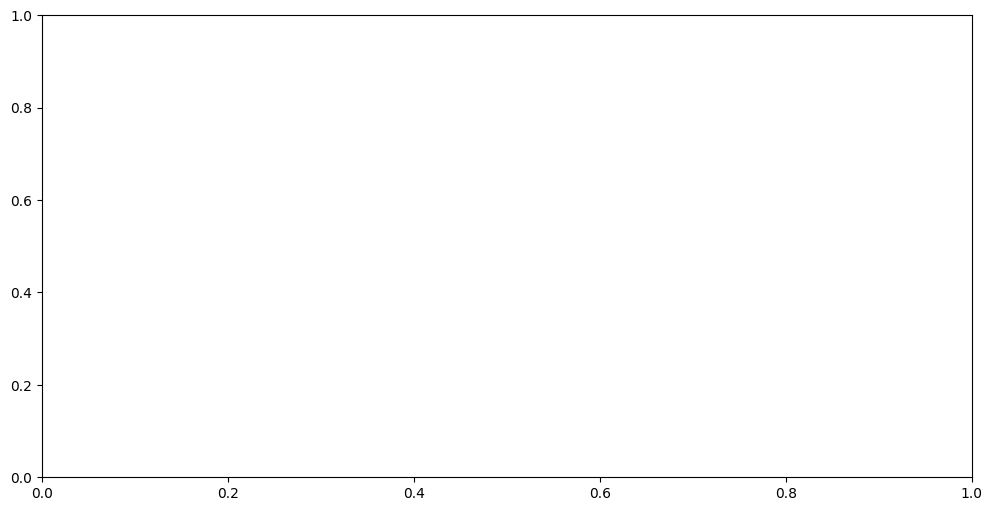

In [17]:
import matplotlib.pyplot as plt
import torch

# Assuming output_seq is the tensor with one-hot encoded vectors
output_seq_plot = output_seq.argmax(dim=1).cpu().numpy()  # Convert one-hot to class indices

# Count occurrences of each class (1-1000)
class_counts = torch.bincount(torch.tensor(output_seq_plot), minlength=50035)  # Ensure length 1001 to include index 1000

# Exclude the count for index 0 if your classes start from 1
class_counts = class_counts[1:]  # Remove count for index 0 if not used

# Plot the counts
plt.figure(figsize=(12, 6))
plt.bar(range(1, 50035), class_counts.numpy())
plt.xlabel('Class Index')
plt.ylabel('Number of Occurrences')
plt.title('Occurrences of Each Class (1-1000) in Output Sequences')
plt.show()
